Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import learning_curve, validation_curve

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score

## Dataset 2: Banknote Authentication

Based on various factors that are based on images our goal is to predict the authenticity of a banknote. I got my data from Kaggle using the link below and I will be using decision trees (with some form of pruning), neural networks, boosting, support vector machines, and k-nearest neighbors.

Dataset Link: https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data

In [16]:
# Read in data
df = pd.read_csv("BankNote_Authentication.csv")
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In these next few cells, we will look at the number of positive and negative samples and then taking the average of each feature for positive and negative samples to see how they compare using a bar chart. 

In [17]:
# Get positive and negative samples
y = df.values[:,-1]
print("Positive samples: ", (y==1).sum())
print("Negative samples: ", (y==0).sum())

Positive samples:  610
Negative samples:  762


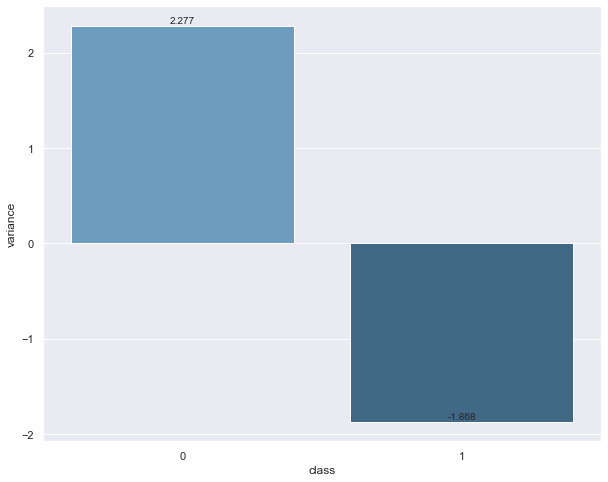

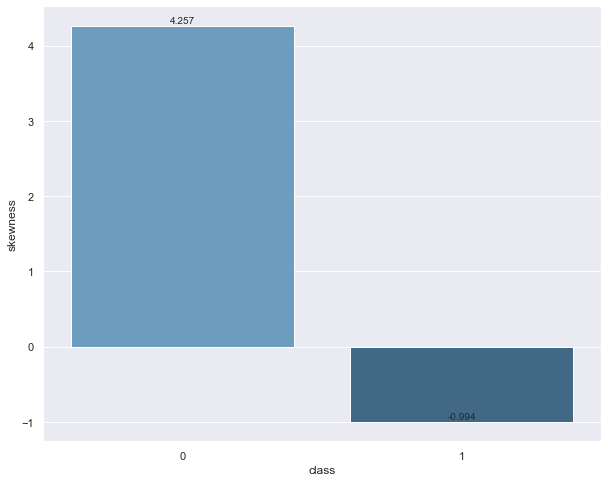

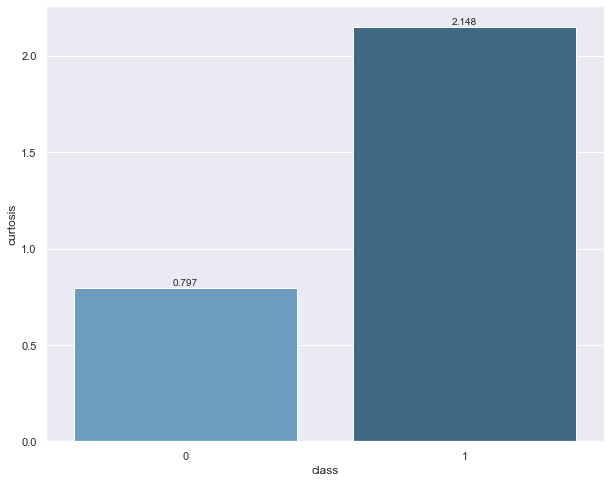

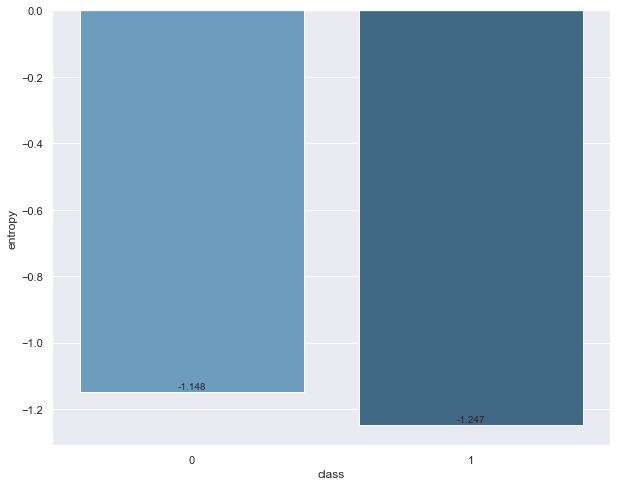

In [19]:
# Making the bar charts
a_dict = {}
colslist = []
for cols in df.columns:
    colslist.append(cols)
colslist.remove('class')
summary_df = df.groupby('class').mean()
for cols in colslist:
    bar_chart_df = summary_df[[str(cols)]]
    a_dict[cols] = ((bar_chart_df.loc[1]-bar_chart_df.loc[0])/abs(bar_chart_df.loc[0]))*100

# Getting the list of features to put on the y-axis label
feat_list = []
for k, v in a_dict.items():
    if abs(float(v))>=1.5:
        feat_list.append(k)

# Looping through and generating the charts for each feature
summary_df = df.groupby('class').mean()
sn.set_theme(style="whitegrid")
sn.set(rc = {'figure.figsize':(10,8)})
for cols in colslist:
    plots = sn.barplot(x='class', y=cols, data=df, ci=None, palette="Blues_d")
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.3f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center', size=10, xytext=(0, 5), textcoords='offset points')
    plt.show()

Divide into training and testing data (80/20)

In [20]:
# 80-20 split for the training and testing data
X_train, X_test, y_train, y_test = train_test_split(df.values[:,:-2], df.values[:,-1], test_size=0.2, random_state=42)

The algorithms will work better when features are on a similar scale and normally distributed. We will use a standard scaler to normalize the data

In [21]:
# Using a standard scaler to scale features down
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_
X_train = scaler.transform(X_train)
scaler.fit(X_test)
scaler.mean_
X_test = scaler.transform(X_test)

### 1.1 Decision Tree

We will now fit the data using a decision tree classifier with pruning. 

In [22]:
# Create a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=0)

Accuracy of the best model: 98.18%
Best Parameters: {'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


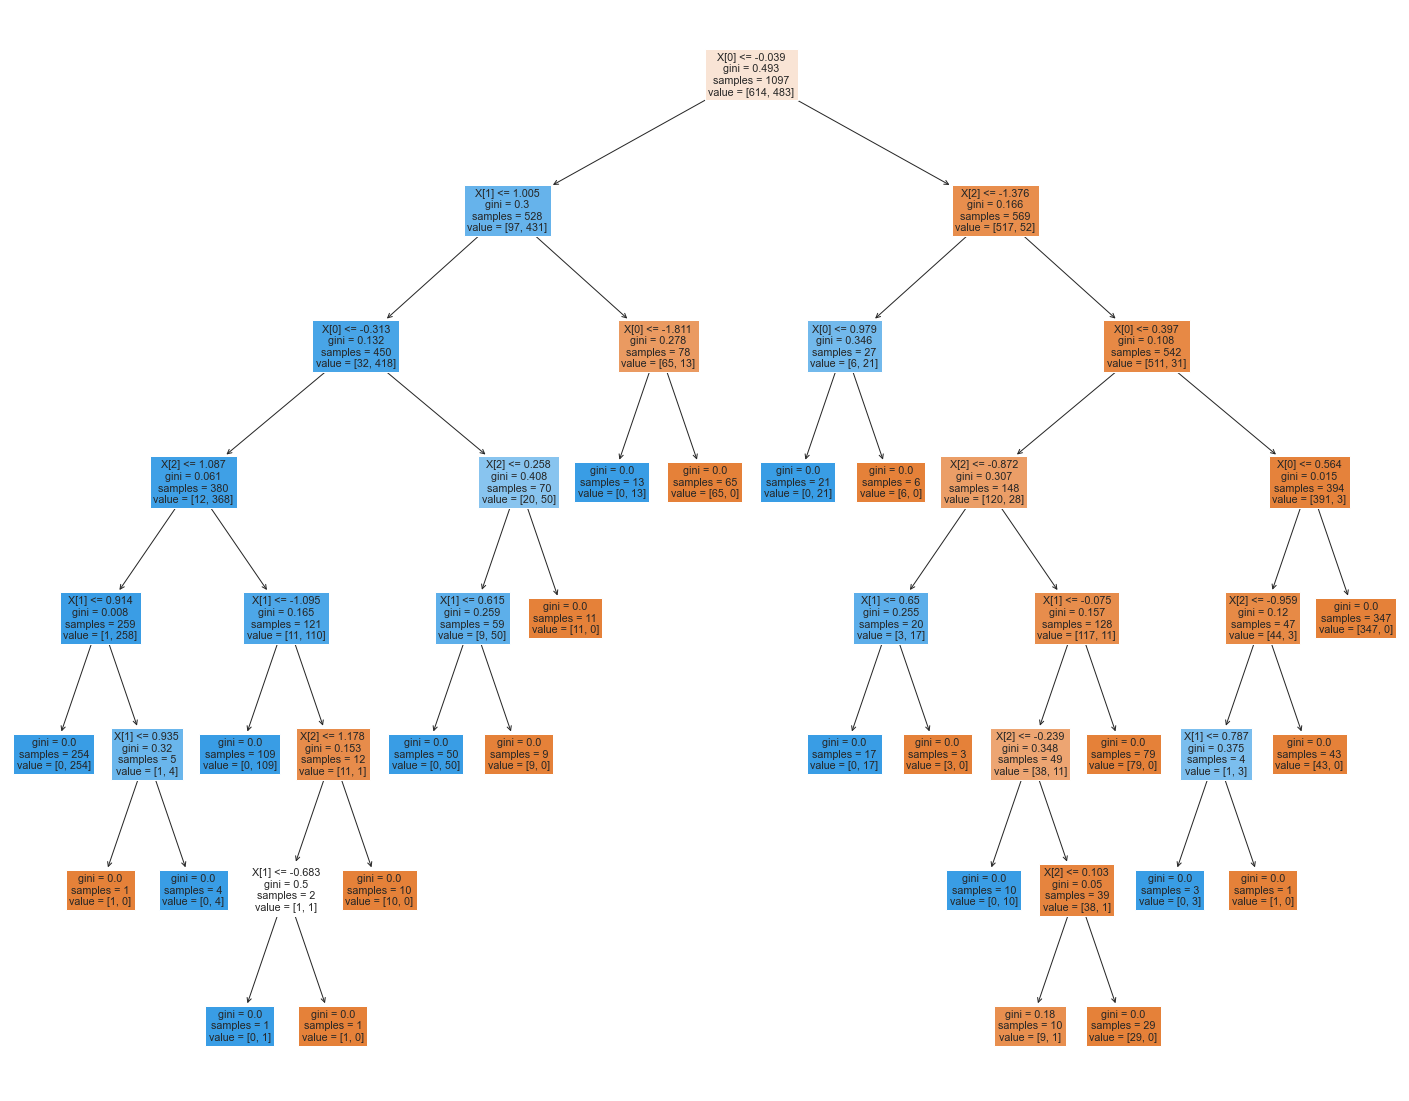

In [23]:
# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'max_leaf_nodes': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator from GridSearchCV
best_dt = grid_search.best_estimator_

# Calculate and display the accuracy of the best model
accuracy = best_dt.score(X_test, y_test)
print(f"Accuracy of the best model: {accuracy * 100:.2f}%")
print("Best Parameters:", grid_search.best_params_)

plt.figure(figsize=(25,20))
tree.plot_tree(best_dt, filled=True)
plt.show()

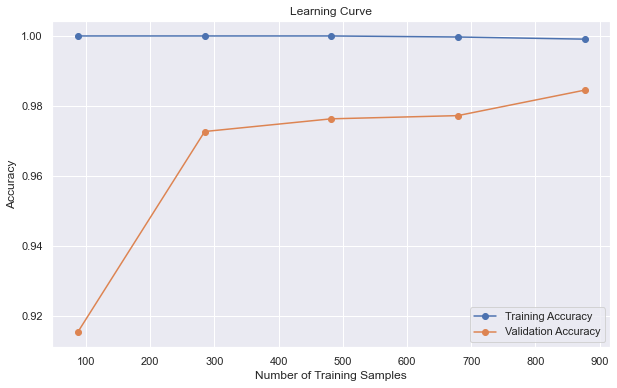

In [24]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(best_dt, X_train, y_train, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", marker="o")
plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker="o")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()

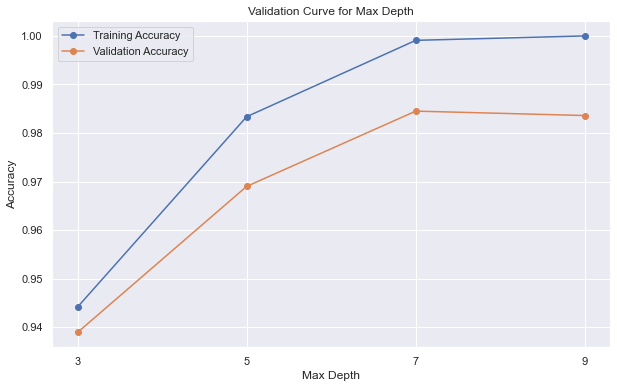

In [25]:
# Plot validation curve for max_depth
param_range = [3, 5, 7, 9]
train_scores, test_scores = validation_curve(best_dt, X_train, y_train, param_name="max_depth", param_range=param_range, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Accuracy", marker="o")
plt.plot(param_range, test_mean, label="Validation Accuracy", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Validation Curve for Max Depth")
plt.xticks(param_range)
plt.show()

In [36]:
# Make predictions on the test set
y_pred = best_dt.predict(X_test)

# Calculate error percentage
error_percentage = 100 * (1 - accuracy_score(y_test, y_pred))
print(f"Error Percentage: {error_percentage:.2f}%")

# Calculate precision, recall, and F1 score
classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("Classification Report:\n", classification_rep)

Error Percentage: 1.82%
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.99      0.98       148
    Positive       0.99      0.97      0.98       127

    accuracy                           0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275



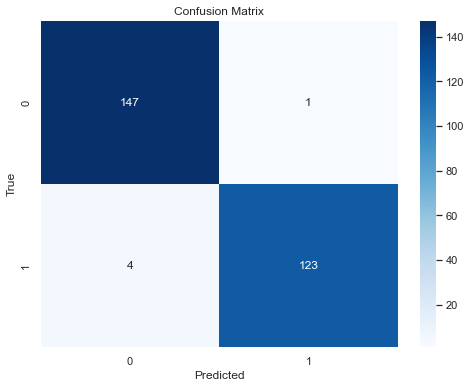

In [28]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### 1.2 Neural Network

We will now test with a neural network to see if we can improve the accuracy.

In [29]:
# Create a Multi-layer Perceptron (MLP) Classifier
mlp = MLPClassifier(random_state=0)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (10, 10), (20, 20)],
    'learning_rate_init': [0.0005, 0.001, 0.01],
    'activation': ['relu', 'logistic'],
    'max_iter': [200, 300, 450]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator from GridSearchCV
best_mlp = grid_search.best_estimator_

# Calculate and display the accuracy of the best model
best_accuracy = best_mlp.score(X_test, y_test)
print(f"Accuracy of the best model: {best_accuracy * 100:.2f}%")
print("Best Parameters:", grid_search.best_params_)

/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Accuracy of the best model: 100.00%
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'max_iter': 200}


/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ishansheth/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

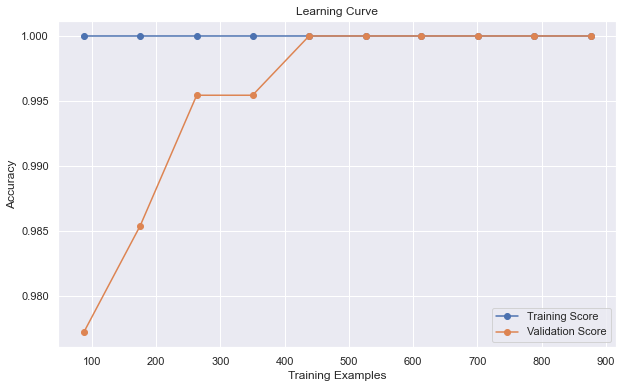

In [30]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()

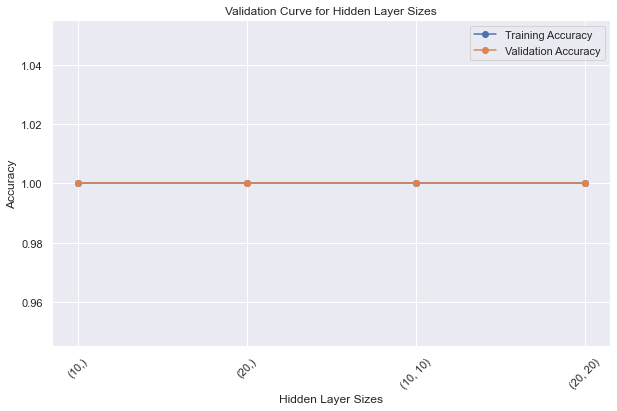

In [31]:
# Plot validation curve for hidden_layer_sizes
param_range = [(10,), (20,), (10, 10), (20, 20)]
train_scores, test_scores = validation_curve(
    best_mlp, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=5, scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(range(len(param_range)), np.mean(train_scores, axis=1), 'o-', label="Training Accuracy")
plt.plot(range(len(param_range)), np.mean(test_scores, axis=1), 'o-', label="Validation Accuracy")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Accuracy")
plt.xticks(range(len(param_range)), param_range, rotation=45)
plt.legend(loc="best")
plt.title("Validation Curve for Hidden Layer Sizes")
plt.show()

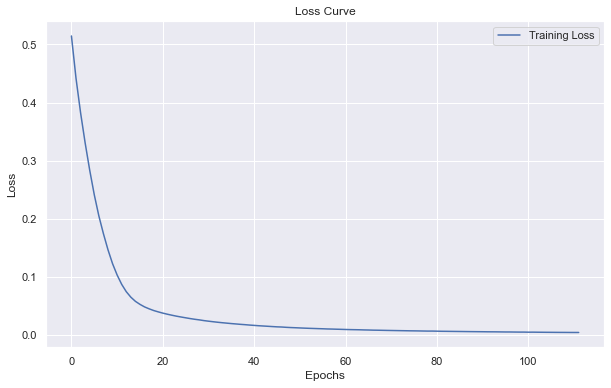

In [32]:
# Train the best model with the entire training set
best_mlp.fit(X_train, y_train)

# Plot loss curve for training
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title("Loss Curve")
plt.show()

In [34]:
# Make predictions on the test set
y_pred = best_mlp.predict(X_test)

# Calculate and display error percentage
error_percentage = 100 * (1 - best_accuracy)
print(f"Error Percentage: {error_percentage:.2f}%")

# Calculate and display precision, recall, and F1 score
classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("Classification Report:\n", classification_rep)

Error Percentage: 0.00%
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       148
    Positive       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



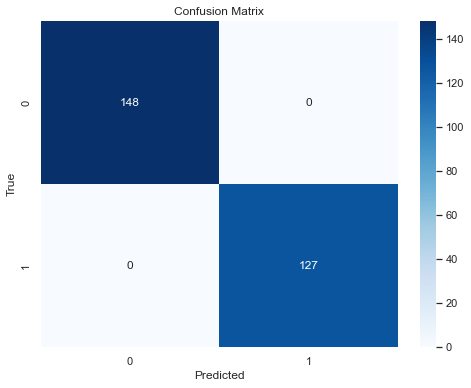

In [35]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### 1.3 Boosting

We will now test with a boosting classifier adjusting the number of weak learners

In [37]:
# Create a GradientBoostingClassifier
boosting = GradientBoostingClassifier(random_state=0)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 250],            # Number of weak learners (trees)
    'learning_rate': [0.01, 0.1, 0.2],        # Learning rate
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(boosting, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator from GridSearchCV
best_boosting = grid_search.best_estimator_

# Calculate and display the accuracy of the best model
best_accuracy = best_boosting.score(X_test, y_test)
print(f"Accuracy of the best model: {best_accuracy * 100:.2f}%")
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred = best_boosting.predict(X_test)

# Calculate error percentage
error_percentage = 100 * (1 - accuracy_score(y_test, y_pred))
print(f"Error Percentage: {error_percentage:.2f}%")

Accuracy of the best model: 99.27%
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 200}
Error Percentage: 0.73%


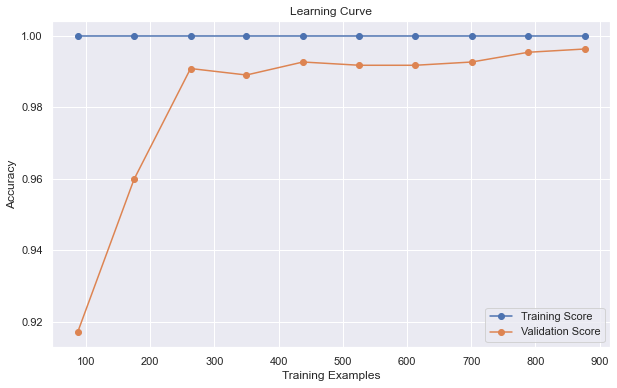

In [38]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_boosting, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()

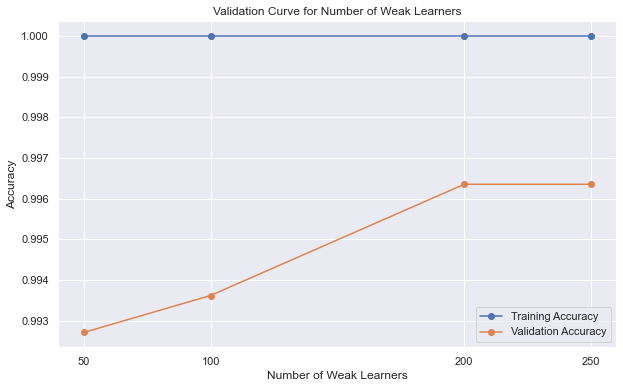

In [39]:
# Plot validation curve for n_estimators
param_range = [50, 100, 200, 250]
train_scores, test_scores = validation_curve(
    best_boosting, X_train, y_train, param_name="n_estimators", param_range=param_range, cv=5
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training Accuracy", marker="o")
plt.plot(param_range, np.mean(test_scores, axis=1), label="Validation Accuracy", marker="o")
plt.xlabel("Number of Weak Learners")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Validation Curve for Number of Weak Learners")
plt.xticks(param_range)
plt.show()

In [40]:
# Calculate precision, recall, and F1 score
classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.99      0.99      0.99       148
    Positive       0.99      0.99      0.99       127

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



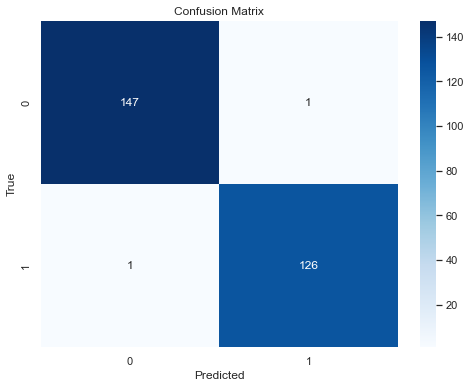

In [41]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### 1.4 Support Vector Machines - Linear Kernel

Next we will be looking at the data using support vector machines, one with a linear kernel and one with a polynomial kernel. We will start with linear.

In [42]:
# Create an SVM classifier with a linear kernel
svm_linear = SVC(kernel='linear', random_state=0)

# Define the hyperparameter grid for linear SVM
param_grid_linear = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Perform GridSearchCV for linear SVM
grid_search_linear = GridSearchCV(svm_linear, param_grid_linear, cv=5)
grid_search_linear.fit(X_train, y_train)

# Get the best estimator from GridSearchCV for linear SVM
best_svm_linear = grid_search_linear.best_estimator_

# Calculate and display the accuracy of the best linear SVM model
accuracy_linear = best_svm_linear.score(X_test, y_test)
print(f"Accuracy of the best linear SVM model: {accuracy_linear * 100:.2f}%")
print("Best Parameters for Linear SVM:", grid_search_linear.best_params_)
# Make predictions on the test set for linear SVM
y_pred_linear = best_svm_linear.predict(X_test)

# Calculate error percentage for linear SVM
error_percentage_linear = 100 * (1 - accuracy_linear)
print(f"Error Percentage for Linear SVM: {error_percentage_linear:.2f}%")

Accuracy of the best linear SVM model: 98.55%
Best Parameters for Linear SVM: {'C': 100, 'gamma': 'scale'}
Error Percentage for Linear SVM: 1.45%


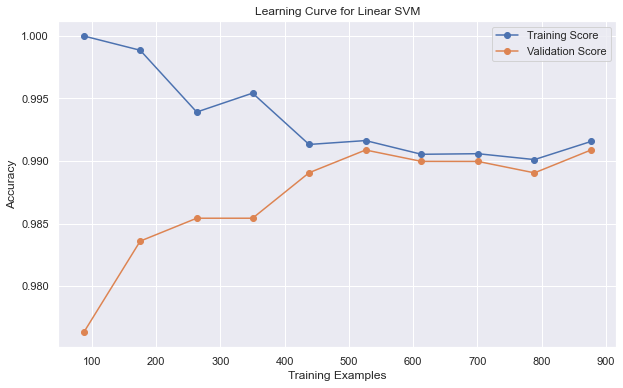

In [43]:
# Plot learning curve for linear SVM
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_linear, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Learning Curve for Linear SVM")
plt.show()

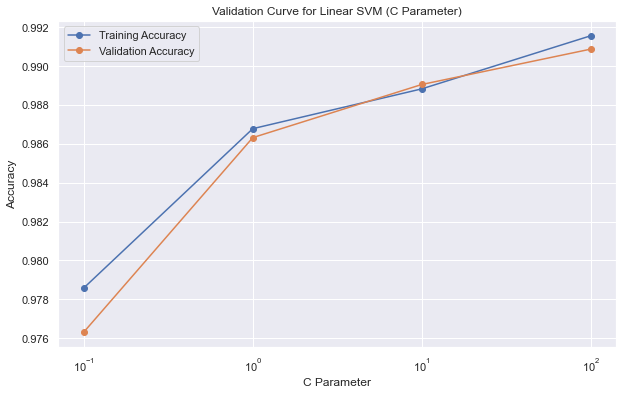

In [44]:
# Plot validation curve for linear SVM (C parameter)
param_range = [0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(
    best_svm_linear, X_train, y_train, param_name="C", param_range=param_range, cv=5
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training Accuracy", marker="o")
plt.plot(param_range, np.mean(test_scores, axis=1), label="Validation Accuracy", marker="o")
plt.xlabel("C Parameter")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Validation Curve for Linear SVM (C Parameter)")
plt.xscale('log')
plt.show()

Error Percentage for Linear SVM: 1.45%


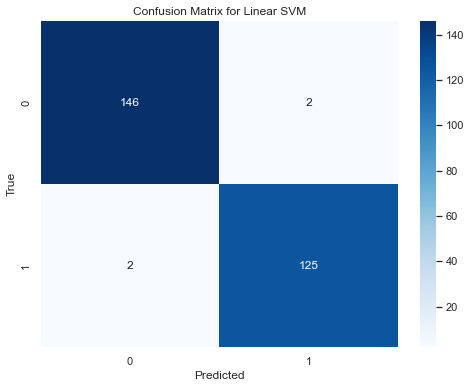

Classification Report for Linear SVM:
               precision    recall  f1-score   support

    Negative       0.99      0.99      0.99       148
    Positive       0.98      0.98      0.98       127

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



In [45]:
# Make predictions on the test set for linear SVM
y_pred_linear = best_svm_linear.predict(X_test)

# Calculate error percentage for linear SVM
error_percentage_linear = 100 * (1 - accuracy_linear)
print(f"Error Percentage for Linear SVM: {error_percentage_linear:.2f}%")

# Generate and display the confusion matrix for linear SVM
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix_linear, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Linear SVM")
plt.show()

# Calculate precision, recall, and F1 score for linear SVM
classification_rep_linear = classification_report(y_test, y_pred_linear, target_names=["Negative", "Positive"])
print("Classification Report for Linear SVM:\n", classification_rep_linear)

### 1.5 Support Vector Machines - Polynomial Kernel

Now we will try with a polynomial kernel.

In [46]:
# Create an SVM classifier with a polynomial kernel
svm_poly = SVC(kernel='poly', random_state=0)

# Define the hyperparameter grid for polynomial SVM
param_grid_poly = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'degree': [2, 3, 4],  # Degree of the polynomial kernel
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Perform GridSearchCV for polynomial SVM
grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5)
grid_search_poly.fit(X_train, y_train)

# Get the best estimator from GridSearchCV for polynomial SVM
best_svm_poly = grid_search_poly.best_estimator_

# Calculate and display the accuracy of the best polynomial SVM model
accuracy_poly = best_svm_poly.score(X_test, y_test)
print(f"Accuracy of the best polynomial SVM model: {accuracy_poly * 100:.2f}%")
print("Best Parameters for Polynomial SVM:", grid_search_poly.best_params_)

# Make predictions on the test set for polynomial SVM
y_pred_poly = best_svm_poly.predict(X_test)

# Calculate error percentage for polynomial SVM
error_percentage_poly = 100 * (1 - accuracy_poly)
print(f"Error Percentage for Polynomial SVM: {error_percentage_poly:.2f}%")

Accuracy of the best polynomial SVM model: 99.64%
Best Parameters for Polynomial SVM: {'C': 100, 'degree': 3, 'gamma': 'scale'}
Error Percentage for Polynomial SVM: 0.36%


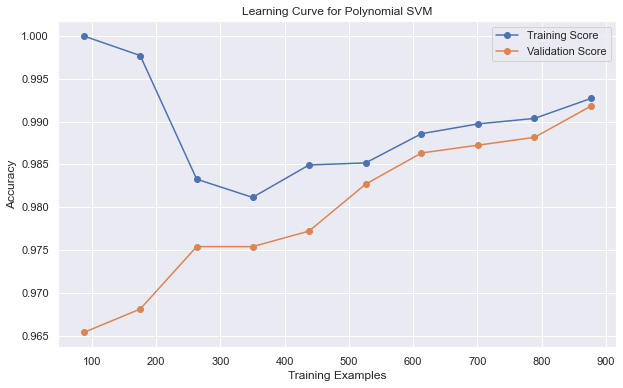

In [47]:
# Plot learning curve for polynomial SVM
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_poly, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Learning Curve for Polynomial SVM")
plt.show()

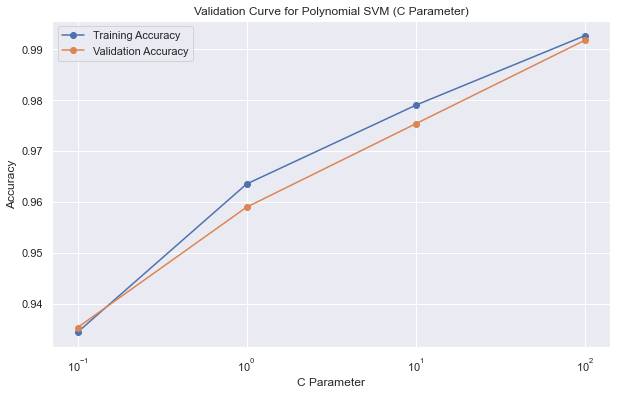

In [48]:
# Plot validation curve for polynomial SVM (C parameter)
param_range = [0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(
    best_svm_poly, X_train, y_train, param_name="C", param_range=param_range, cv=5
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training Accuracy", marker="o")
plt.plot(param_range, np.mean(test_scores, axis=1), label="Validation Accuracy", marker="o")
plt.xlabel("C Parameter")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Validation Curve for Polynomial SVM (C Parameter)")
plt.xscale('log')
plt.show()

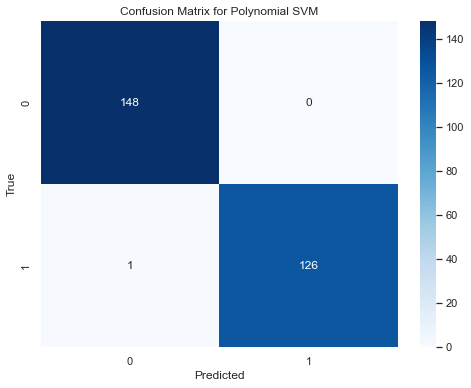

Classification Report for Polynomial SVM:
               precision    recall  f1-score   support

    Negative       0.99      1.00      1.00       148
    Positive       1.00      0.99      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



In [49]:
# Generate and display the confusion matrix for polynomial SVM
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix_poly, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Polynomial SVM")
plt.show()

# Calculate precision, recall, and F1 score for polynomial SVM
classification_rep_poly = classification_report(y_test, y_pred_poly, target_names=["Negative", "Positive"])
print("Classification Report for Polynomial SVM:\n", classification_rep_poly)

### 1.6 K-Nearest Neighbors

Finally, we will take a look at KNN varying the levels of nearest neighbors.

In [50]:
# Create a K-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],  # Number of neighbors (k)
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'p': [1, 2]  # Distance metric (1 for Manhattan, 2 for Euclidean)
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator from GridSearchCV
best_knn = grid_search.best_estimator_

# Calculate and display the accuracy of the best model
best_accuracy = best_knn.score(X_test, y_test)
print(f"Accuracy of the best KNN model: {best_accuracy * 100:.2f}%")
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred = best_knn.predict(X_test)

# Calculate error percentage
error_percentage = 100 * (1 - accuracy_score(y_test, y_pred))
print(f"Error Percentage: {error_percentage:.2f}%")

Accuracy of the best KNN model: 100.00%
Best Parameters: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
Error Percentage: 0.00%


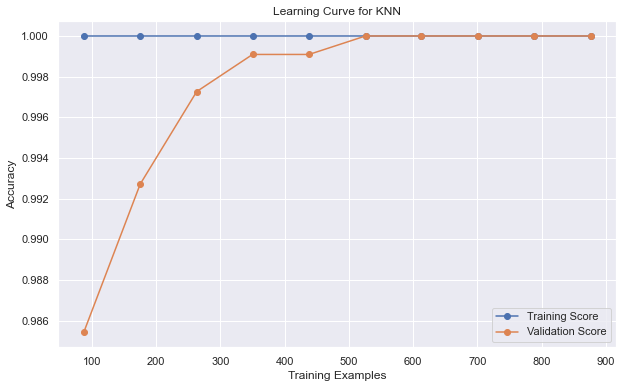

In [51]:
# Plot learning curve for KNN
train_sizes, train_scores, test_scores = learning_curve(
    best_knn, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Learning Curve for KNN")
plt.show()

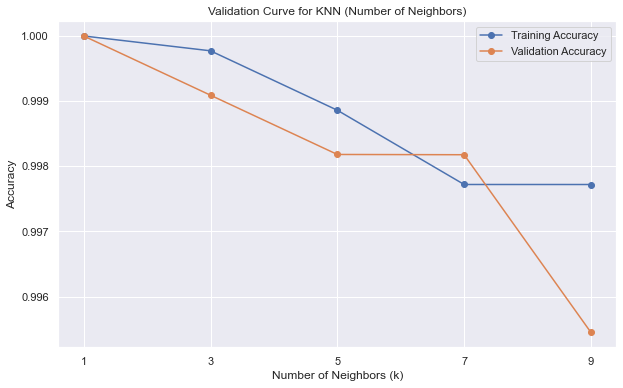

In [52]:
# Plot validation curve for KNN (number of neighbors - k)
param_range = [1, 3, 5, 7, 9]
train_scores, test_scores = validation_curve(
    best_knn, X_train, y_train, param_name="n_neighbors", param_range=param_range, cv=5
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training Accuracy", marker="o")
plt.plot(param_range, np.mean(test_scores, axis=1), label="Validation Accuracy", marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Validation Curve for KNN (Number of Neighbors)")
plt.xticks(param_range)
plt.show()

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       148
    Positive       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



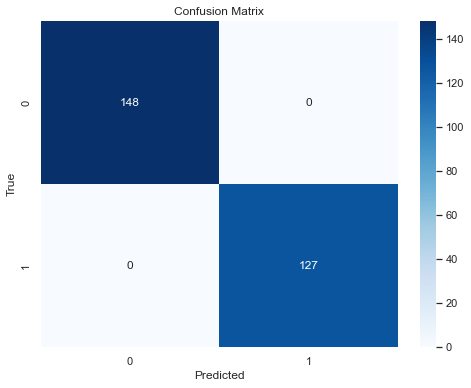

In [53]:
# Calculate precision, recall, and F1 score
classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("Classification Report:\n", classification_rep)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### 1.7 Final Analysis

The neural network performed the best leading the models in accuracy. Considering that the data is fairly imbalanced, I also wanted to look at the F1 score which takes into account precision and recall - to identify the number of positive predictions.

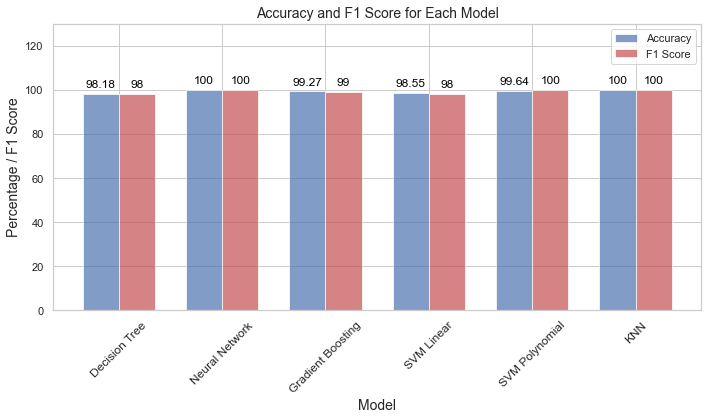

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

categories = ["Decision Tree", "Neural Network", "Gradient Boosting", "SVM Linear", "SVM Polynomial", "KNN"]
percentages = [98.18, 100, 99.27, 98.55, 99.64, 100]
f1scores = [98, 100, 99, 98, 100, 100]

# Create a figure and axis
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create a bar plot for accuracy
bar_width = 0.35
index = np.arange(len(categories))

plt.bar(index, percentages, bar_width, label='Accuracy', color='b', alpha=0.7)
plt.bar(index + bar_width, f1scores, bar_width, label='F1 Score', color='r', alpha=0.7)

plt.title("Accuracy and F1 Score for Each Model", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Percentage / F1 Score", fontsize=14)
plt.ylim(0, 130)
plt.xticks(index + bar_width / 2, categories, rotation=45, fontsize=12)

# Display the percentages above the bars
for i, percentage in enumerate(percentages):
    plt.text(index[i], percentage + 2, f"{percentage}", ha="center", va="bottom", fontsize=12, color="black")

# Display the F1 scores above the bars
for i, f1score in enumerate(f1scores):
    plt.text(index[i] + bar_width, f1score + 2, f"{f1score}", ha="center", va="bottom", fontsize=12, color="black")

plt.legend()
plt.tight_layout()
plt.show()